In this notebook we implement an easier library layer, a regression layer and the pruning with pytorch/

In [1]:
# General imports
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

#Plotting imports
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Remainder imports
from os import listdir, path, getcwd

# Setting cuda
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

# Settings for reproducibility
np.random.seed(42)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Defining output folder
output_folder = getcwd()

%load_ext autoreload
%autoreload 2

# DeepMoD stuff
from deepymod_torch.utilities import create_deriv_data
from deepymod_torch.network import Linear, Tanh
from deepymod_torch.output import progress


/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

# Implementing new layers

## Library layer

We implement a simpler library layer for now use in the network. Let's not worry about deepmod for now and just make it easy:

In [2]:
class Library(nn.Module):
    '''Abstract baseclass for library-as-layer. Child requires theta function (see library_functions). '''
    def __init__(self, input_dim, output_dim, diff_order):
        super().__init__()
        self.diff_order = diff_order
        self.total_terms = self.terms(input_dim, output_dim, self.diff_order)

    def forward(self, input):
        '''Calculates output.'''
        time_deriv_list, theta = self.theta(input)
        return input, time_deriv_list, theta

    def terms(self, input_dim, output_dim, max_order):
        '''Calculates the number of terms the library produces'''
        sample_data = (torch.ones((1, output_dim), dtype=torch.float32), torch.ones((1, max_order, input_dim, output_dim), dtype=torch.float32)) # we run a single forward pass on fake data to infer shapes
        total_terms = self.theta(sample_data)[1].shape[1]

        return total_terms

In [3]:
class library_basic(Library):
    '''Implementation of library layer. Inherets from Library layer.'''
    def __init__(self, input_dim, output_dim, diff_order, poly_order):
        self.poly_order = poly_order
        super().__init__(input_dim, output_dim, diff_order)
    
    def theta(self, input):
        '''Calculates the library and time deriv from NN output'''
        X, dX = input
        samples = X.shape[0]

        # Time derivatives
        dt = dX[:, 0, :1, :]
        time_deriv_list = torch.unbind(dt, dim=2)

        # Polynomial part
        u = torch.ones_like(X)[:, None, :]
        for order in torch.arange(1, self.poly_order+1):
            u = torch.cat((u, u[:, order-1:order, :] * X[:, None, :]), dim=1)
        poly_list = torch.unbind(u, dim=2) #list with each entry corresponding to eq.

        # Derivative part
        dx = dX[:, :, 1:, :]
        deriv_list = [torch.cat((torch.ones((samples, 1)), eq.reshape(samples, -1)), dim=1) for eq in torch.unbind(dx, dim=3)] #list with each entry corresponding to eq.
        
        # Combining to make  theta
        if len(poly_list) == 1:
            theta = torch.matmul(poly_list[0][:, :, None], deriv_list[0][:, None, :]).reshape(samples, -1) # If we have a single output, we simply calculate and flatten matrix product between polynomials and derivatives to get library
        else:
            theta_uv = torch.cat([torch.matmul(u[:, :, None], v[:, None, :]).reshape(samples, -1) for u, v in combinations(poly_list, 2)], 1)  # calculate all unique combinations between polynomials
            theta_dudv = torch.cat([torch.matmul(du[:, :, None], dv[:, None, :]).reshape(samples, -1)[:, 1:] for du, dv in combinations(deriv_list, 2)], 1) # calculate all unique combinations of derivatives
            theta_udu = torch.cat([torch.matmul(u[:, 1:, None], du[:, None, 1:]).reshape(samples, -1) for u, du in product(poly_list, deriv_list)], 1)  # calculate all unique products of polynomials and derivatives
            theta = torch.cat([theta_uv, theta_dudv, theta_udu], dim=1)

        return time_deriv_list, theta

The regression layer is a simple linear layer, but we also need to forward the output so let's build a simple wrapper:

In [4]:
class Regression(nn.Linear):
    '''Pytorch style linear layer which also calculates the derivatives w.r.t input. Has been written to be a thin wrapper around the pytorch layer. '''
    def __init__(self, in_features, out_features):
        super().__init__(in_features, out_features, bias=False)
        
    def forward(self, input):
        '''Calculates output'''
        z = F.linear(input[2], self.weight)
        
        return (input, z)


## Building model

In [5]:
def build_network(input_dim, hidden_dim, layers, output_dim, library_function, library_args):
    ''' Build deepmod model.'''
    network = [Linear(input_dim, hidden_dim), Tanh()]  # Input layer
    for hidden_layer in torch.arange(layers):  # Hidden layers
        network.append(Linear(hidden_dim, hidden_dim))
        network.append(Tanh())
    network.append(Linear(hidden_dim, output_dim))  # Output layer
    
    network.append(library_function(input_dim, output_dim, **library_args)) # Library layer
    network.append(Regression(network[-1].total_terms, 1)) # Regression layer
    torch_network = nn.Sequential(*network)

    return torch_network

# Testing new model

In [6]:
# Loading data
data = np.load('../../tests/data/burgers.npy', allow_pickle=True).item()
X = np.transpose((data['t'].flatten(), data['x'].flatten()))
y = np.real(data['u']).reshape((data['u'].size, 1))
number_of_samples = 1500

idx = np.random.permutation(y.size)
X_train = torch.tensor(X[idx, :][:number_of_samples], dtype=torch.float32)
y_train = torch.tensor(y[idx, :][:number_of_samples], dtype=torch.float32)

## Running DeepMoD
config = {'input_dim': 2, 'hidden_dim': 20, 'layers': 5, 'output_dim': 1, 'library_function': library_basic, 'library_args':{'poly_order': 2, 'diff_order': 2}}

X_input = create_deriv_data(X_train, config['library_args']['diff_order'])

In [7]:
model = build_network(**config)

In [8]:
%%timeit
model(X_input)

3.02 ms ± 10.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Now, time to train without l1 and pruning

In [9]:
optimizer = torch.optim.Adam(model.parameters())
max_iterations = 10000

In [ ]:
print('| Iteration | Progress | Time remaining |     Cost |      MSE |      Reg |       L1 |')
for iteration in torch.arange(0, max_iterations + 1):
    (prediction, time_deriv_list, theta), f = model(X_input)
    loss_mse = torch.mean((prediction[0] - y_train)**2)
    loss_reg = torch.mean((time_deriv_list[0] - f)**2)
    loss = loss_mse + loss_reg
        
    # Writing
    if iteration % 100 == 0:
        progress(iteration, 0, max_iterations, loss.item(), loss_mse.item(), loss_reg.item(), 0)
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()



let's look at the weights...

In [47]:
model[-1].weight

Parameter containing:
tensor([[ 4.0682e-05,  6.0732e-03,  9.9576e-02,  1.2170e-02, -1.1053e+00,
         -2.7602e-02, -3.8416e-02,  2.1788e-01,  1.7072e-02]],
       requires_grad=True)

Let's try and rescale it:

In [48]:
rescaled_weights = (model[-1].weight * torch.norm(model[:-1](X_input)[2], dim=0)).cpu().detach().numpy().squeeze()

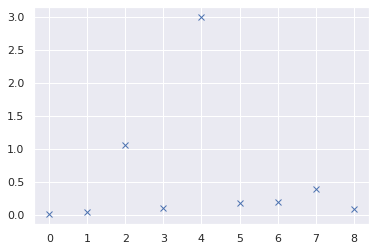

In [49]:
plt.plot(np.abs(rescaled_weights), 'x')

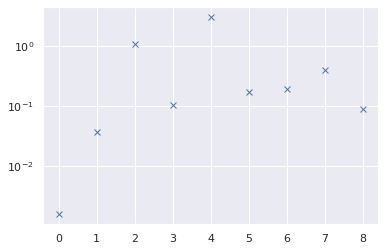

In [50]:
plt.semilogy(np.abs(rescaled_weights), 'x')

So that's not bad for after 10k its.

## Adding pruning into the mix

In [96]:
# Loading data
data = np.load('../../tests/data/burgers.npy', allow_pickle=True).item()
X = np.transpose((data['t'].flatten(), data['x'].flatten()))
y = np.real(data['u']).reshape((data['u'].size, 1))
number_of_samples = 500

idx = np.random.permutation(y.size)
X_train = torch.tensor(X[idx, :][:number_of_samples], dtype=torch.float32)
y_train = torch.tensor(y[idx, :][:number_of_samples], dtype=torch.float32)

## Running DeepMoD
config = {'input_dim': 2, 'hidden_dim': 20, 'layers': 5, 'output_dim': 1, 'library_function': library_basic, 'library_args':{'poly_order': 2, 'diff_order': 2}}

X_input = create_deriv_data(X_train, config['library_args']['diff_order'])

Now we'll add pruning into the mix. We need to build our own pruning method. For now we do it not very compact in the training loop.

In [97]:
from torch.nn.utils import prune

In [98]:
model = build_network(**config)

In [100]:
optimizer = torch.optim.Adam(model.parameters())
threshold = 1e-4
max_iterations = 2000

We only apply pruning after the mse has converged enough:

In [101]:
print('| Iteration | Progress | Time remaining |     Cost |      MSE |      Reg |       L1 |')
for iteration in torch.arange(0, max_iterations + 1):
    (prediction, time_deriv_list, theta), f = model(X_input)
    loss_mse = torch.mean((prediction[0] - y_train)**2)
    loss_reg = torch.mean((time_deriv_list[0] - f)**2)
    loss = loss_mse + loss_reg
    
    # Writing
    if iteration % 100 == 0:
        progress(iteration, 0, max_iterations, loss.item(), loss_mse.item(), loss_reg.item(), 0)
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()



| Iteration | Progress | Time remaining |     Cost |      MSE |      Reg |       L1 |
       2000    100.00%               0s   1.51e-04   9.28e-05   5.78e-05   0.00e+00 

In [102]:
model[-1].weight * torch.norm(theta, dim=0) / torch.norm(time_deriv_list[0])

tensor([[ 0.0537, -0.3621,  0.2435, -0.2996, -0.8363,  0.5636,  0.4016,  0.0908,
         -0.2901]], grad_fn=<DivBackward0>)

In [103]:
np.linalg.lstsq(theta.cpu().detach().numpy(), time_deriv_list[0].cpu().detach().numpy(), rcond=None)[0]

array([[ 0.00117483],
       [-0.08605842],
       [ 0.06933831],
       [-0.00996884],
       [-0.9838677 ],
       [ 0.12882902],
       [ 0.01307354],
       [ 0.51698136],
       [-0.13619334]], dtype=float32)

In [118]:
optimizer = torch.optim.Adam(model.parameters())
threshold = 5e-2
max_iterations = 5000

In [119]:
print('| Iteration | Progress | Time remaining |     Cost |      MSE |      Reg |       L1 |')
for iteration in torch.arange(0, max_iterations + 1):
    (prediction, time_deriv_list, theta), f = model(X_input)
    loss_mse = torch.mean((prediction[0] - y_train)**2)
    loss_reg = torch.mean((time_deriv_list[0] - f)**2)
    loss = loss_mse + loss_reg
    
    # Writing
    if iteration % 100 == 0:
        progress(iteration, 0, max_iterations, loss.item(), loss_mse.item(), loss_reg.item(), 0)
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    rescaled_weights = model[-1].weight * torch.norm(theta, dim=0) / torch.norm(time_deriv_list[0])
    mask = torch.abs(rescaled_weights) > threshold
    prune.custom_from_mask(model[-1], name='weight', mask=mask)


| Iteration | Progress | Time remaining |     Cost |      MSE |      Reg |       L1 |
       5000    100.00%               0s   4.31e-07   2.22e-07   2.09e-07   0.00e+00 

In [120]:
mask

tensor([[False, False,  True, False,  True, False, False, False, False]])

In [121]:
model[-1].weight.cpu().detach().numpy().squeeze()

array([-0.        , -0.        ,  0.10001196, -0.        , -1.0006839 ,
        0.        ,  0.        ,  0.        ,  0.        ], dtype=float32)

In [122]:
rescaled_weights

tensor([[-0.0000, -0.0000,  0.3870, -0.0000, -0.9944,  0.0000,  0.0000,  0.0000,
          0.0000]], grad_fn=<DivBackward0>)

In [109]:
1e-2

0.01

## Adding l1 

In [145]:
# Loading data
data = np.load('../../tests/data/burgers.npy', allow_pickle=True).item()
X = np.transpose((data['t'].flatten(), data['x'].flatten()))
y = np.real(data['u']).reshape((data['u'].size, 1))
number_of_samples = 500

idx = np.random.permutation(y.size)
X_train = torch.tensor(X[idx, :][:number_of_samples], dtype=torch.float32)
y_train = torch.tensor(y[idx, :][:number_of_samples], dtype=torch.float32)

## Running DeepMoD
config = {'input_dim': 2, 'hidden_dim': 20, 'layers': 5, 'output_dim': 1, 'library_function': library_basic, 'library_args':{'poly_order': 2, 'diff_order': 2}}

X_input = create_deriv_data(X_train, config['library_args']['diff_order'])

In [146]:
model = build_network(**config)

In [147]:
optimizer = torch.optim.Adam(model.parameters())
threshold = 1e-1
l1 = 1e-5
max_iterations = 10000

In [148]:
print('| Iteration | Progress | Time remaining |     Cost |      MSE |      Reg |       L1 |')
for iteration in torch.arange(0, max_iterations + 1):
    (prediction, time_deriv_list, theta), f = model(X_input)
    
    loss_mse = torch.mean((prediction[0] - y_train)**2)
    loss_reg = torch.mean((time_deriv_list[0] - f)**2)
    rescaled_weights = model[-1].weight * torch.norm(theta, dim=0) / torch.norm(time_deriv_list[0])
    loss_l1 = l1 * torch.sum(torch.abs(rescaled_weights))
    loss = loss_mse + loss_reg + loss_l1
    
    # Writing
    if iteration % 100 == 0:
        progress(iteration, 0, max_iterations, loss.item(), loss_mse.item(), loss_reg.item(), loss_l1.item())
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if iteration > 5000:
        mask = torch.abs(rescaled_weights) > threshold
        prune.custom_from_mask(model[-1], name='weight', mask=mask)


| Iteration | Progress | Time remaining |     Cost |      MSE |      Reg |       L1 |
      10000    100.00%               0s   1.50e-05   5.65e-07   4.90e-07   1.40e-05 

In [149]:
rescaled_weights

tensor([[ 0.0000, -0.0000,  0.4243, -0.0000, -0.9715, -0.0000, -0.0000, -0.0000,
          0.0000]], grad_fn=<DivBackward0>)